In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_iv/forward_model_iv10_s1/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1/plots_meas_original'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
dvar_meas = pd.read_hdf(meas_datafile,'dvar')
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'param')

qoi_meas = pd.read_hdf(meas_datafile,'qoi')

qoi_meas



F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.292988     10.202447     10.157936     10.068842      9.942028   
1     319.713326    311.680040    305.246269    301.256849    291.003992   
2     171.628669    169.025406    158.073357    153.320459    158.689681   
3     255.490087    263.406212    248.650204    191.072936    193.379311   
4     169.661308    155.736160    131.068012    120.460237    113.132208   
5      11.623200     11.522790     11.485159     11.458338     11.334892   
6      31.195179     30.793104     30.730566     30.576065     30.276192   
7      69.230554     68.843726     68.329483     68.201156     67.597278   
8     150.179422    149.474910    147.978382    146.385494    144.246849   
9     123.497759    122.980150    121.288541    121.158893    119.360380   
10    241.011311    237.770535    234.895710    232.139757    228.766429   
11    188.023911    182.209560    177.159020    172.017967    166.335981   
12    356.248809    348.305503    337.111139    324.849469    316.144836   
13     97.698322     91.911165    114.354964    112.676577    101.879081   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.933527      9.899784      9.816825      9.784930      9.716613  ...   
1     278.475044    274.752536    273.223423    267.624397    256.391614  ...   
2     157.512209    147.067530    133.207793    114.915648    109.312189  ...   
3     192.970691    157.444078    131.005377    101.921150     72.523689  ...   
4      93.974540     71.949823     57.866504     49.493270     41.002167  ...   
5      11.293051     11.320542     11.206947     11.150377     11.141497  ...   
6      29.963659     29.745276     29.570581     29.269259     28.896808  ...   
7      66.456888     65.266585     64.066910     63.034934     62.091119  ...   
8     141.770377    139.398776    136.896733    135.392823    133.886400  ...   
9     116.715543    114.625422    112.745620    110.197502    107.388154  ...   
10    221.139446    213.688628    209.061573    206.097833    200.159731  ...   
11    162.174808    158.447923    153.780910    146.588038    139.157964  ...   
12    299.782826    292.176839    284.467388    260.428515    240.398889  ...   
13     95.227836     94.071005     90.683122     81.403601     67.999321  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
qoi_meas_preprocessed


#meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
#dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

#qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
#qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.296788     10.205574     10.161950     10.073487      9.943219   
1     319.779352    311.747859    305.310004    301.307994    291.052387   
2     171.675870    169.061589    158.103149    153.350741    158.728432   
3     255.561578    263.482330    248.702459    191.112573    193.423337   
4     169.706184    155.755448    131.101031    120.469612    113.130104   
5      11.624838     11.523947     11.487458     11.461293     11.335395   
6      31.200539     30.792264     30.732224     30.580233     30.276894   
7      69.233568     68.842020     68.327381     68.199014     67.595073   
8     150.211461    149.495152    147.999755    146.407612    144.265127   
9     123.526875    122.993685    121.299332    121.170892    119.371122   
10    241.075302    237.814939    234.940610    232.185053    228.807393   
11    188.077467    182.244118    177.189778    172.045359    166.358831   
12    356.289523    348.342938    337.152942    324.906405    316.194737   
13     97.748704     91.944864    114.392993    112.689452    101.890084   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.932848      9.898133      9.812126      9.780692      9.713143  ...   
1     278.527277    274.810342    273.276961    267.670406    256.429970  ...   
2     157.553536    147.105122    133.240790    114.931483    109.322211  ...   
3     193.023367    157.498141    131.035870    101.940804     72.543582  ...   
4      93.978311     71.961964     57.870742     49.497148     41.000065  ...   
5      11.292185     11.318596     11.203328     11.143059     11.132492  ...   
6      29.964346     29.746688     29.569510     29.268835     28.897714  ...   
7      66.455947     65.265902     64.064075     63.030589     62.087433  ...   
8     141.788059    139.418343    136.915128    135.413765    133.908431  ...   
9     116.727059    114.638491    112.756318    110.207570    107.400512  ...   
10    221.175056    213.726160    209.100270    206.119219    200.170367  ...   
11    162.200239    158.477975    153.810887    146.616963    139.183722  ...   
12    299.822877    292.228769    284.521563    260.474723    240.432240  ...   
13     95.241581     94.076989     90.692855     81.414035     68.016267  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199561     -0.208397     -0.212769     -0.221579     -0.234253   
1       3.236400      3.210953      3.190095      3.176939      3.142313   
2       2.614309      2.599025      2.532035      2.501506      2.535926   
3       3.012159      3.042673      2.985023      2.721631      2.733629   
4       2.602780      2.517139      2.344692      2.260295      2.197533   
5      -0.078021     -0.086697     -0.089969     -0.092307     -0.103138   
6       0.909239      0.896267      0.894234      0.889193      0.879337   
7       1.706418      1.700815      1.693317      1.691437      1.682543   
8       2.480806      2.476104      2.466042      2.455219      2.440502   
9       2.285199      2.280999      2.267148      2.266079      2.251123   
10      2.953820      2.940282      2.928117      2.916315      2.901677   
11      2.705545      2.674133      2.646023      2.616575      2.582985   
12      3.344605      3.322056      3.289388      3.252338      3.225176   
13      2.050860      1.989798      2.208283      2.193497      2.092762   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235109     -0.238511     -0.246926     -0.250181     -0.257187  ...   
1       3.098304      3.084847      3.079266      3.058560      3.015682  ...   
2       2.528479      2.459868      2.360886      2.213174      2.163184  ...   
3       2.731514      2.528046      2.344214      2.093175      1.752889  ...   
4       2.012000      1.744945      1.527114      1.370812      1.182601  ...   
5      -0.106837     -0.104405     -0.114490     -0.119551     -0.120348  ...   
6       0.868961      0.861646      0.855756      0.845514      0.832707  ...   
7       1.665529      1.647456      1.628904      1.612665      1.597579  ...   
8       2.423184      2.406314      2.388203      2.377156      2.365967  ...   
9       2.228715      2.210645      2.194110      2.171250      2.145426  ...   
10      2.867769      2.833496      2.811605      2.797327      2.768091  ...   
11      2.557651      2.534402      2.504505      2.456602      2.404585  ...   
12      3.172034      3.146335      3.119594      3.031304      2.951275  ...   
13      2.025248      2.013026      1.976347      1.868395      1.688473  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [17]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas.values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD          n         k
0   1.181009  0.103934  1.043818   1.989923  0.286964
1   3.968392  0.487920  1.002297  23.465537  0.000084
2   2.028330  0.296735  1.074735   1.681272  0.105146
3   5.274490  0.360859  1.012992   1.656517  0.144734
4   2.138476  0.359907  1.006092   7.353552  0.001161
5   4.233894  0.164429  1.029296   5.286870  0.642028
6   1.594761  0.120026  1.053500   1.645046  0.094213
7   4.105929  0.155734  1.060255   1.646691  0.464943
8   3.661153  0.186578  1.025396   1.613160  0.302788
9   3.161546  0.176116  1.111496   1.698840  0.355407
10  5.432443  0.224345  1.065212   1.684470  0.348594
11  2.572979  0.290138  1.066451   1.651761  0.209519
12  7.284306  0.329525  1.077703   1.546992  0.494771
13  1.644964  0.434836  1.062513   1.402449  0.927469

In [18]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n         k
0   0.166369  4.643752 -3.127703 -0.415632 -1.248399
1   1.378361  6.190152 -6.076233  3.097184 -9.387247
2   0.707213  5.692841 -2.593808 -1.046195 -2.252406
3   1.662882  5.888488 -4.343393 -1.119274 -1.932860
4   0.760093  5.885845 -5.100824  1.795677 -6.758312
5   1.443122  5.102477 -3.530309  1.375453 -0.443123
6   0.466724  4.787705 -2.928074 -1.155036 -2.362199
7   1.412432  5.048151 -2.809174 -1.149829 -0.765840
8   1.297778  5.228850 -3.673158 -1.261743 -1.194723
9   1.151061  5.171142 -2.193769 -0.997394 -1.034491
10  1.692389  5.413186 -2.730105 -1.037130 -1.053848
11  0.945064  5.670356 -2.711296 -1.133945 -1.562941
12  1.985722  5.797654 -2.554863 -1.527895 -0.703661
13  0.497718  6.074969 -2.772383 -2.624878 -0.075296

In [19]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed.values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD          n         k
0   1.359146  0.100378  1.069150   1.644380  0.008474
1   3.659420  0.480810  1.002297  23.206658  0.000087
2   1.946262  0.268885  1.057098   1.640884  0.099878
3   4.761372  0.364357  1.014028   1.651433  0.139189
4   2.587599  0.378647  1.005135   8.622792  0.001046
5   1.793999  0.093515  1.040409   1.761268  0.844879
6   1.651121  0.119324  1.048744   1.654338  0.082824
7   3.989515  0.152426  1.065014   1.622826  0.462690
8   3.564017  0.174617  1.018030   1.611873  0.252321
9   3.234522  0.176945  1.097483   1.641832  0.329009
10  5.885392  0.225217  1.062253   1.715426  0.349177
11  2.580747  0.284826  1.061915   1.632947  0.201027
12  7.155289  0.321264  1.071352   1.523352  0.455716
13  1.704575  0.401045  1.039326   1.338568  0.906988

In [20]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt.values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD          n         k
0   1.155757  0.101580  1.062378   1.660750  0.034567
1   5.792536  0.274670  1.048484   2.031289  0.007894
2   1.833125  0.253224  1.042142   1.762049  0.027736
3   5.308531  0.454096  1.075327   1.663567  0.038986
4   3.709861  0.253557  1.021395   1.784872  0.004739
5   7.662916  0.264851  1.016312  27.312497  0.470393
6   2.047321  0.117046  1.093296   1.620180  0.143942
7   2.229378  0.147399  1.077042   1.659542  0.190791
8   3.789388  0.179056  1.070706   1.653678  0.248839
9   2.423561  0.188649  1.070726   1.623107  0.283691
10  3.815463  0.223706  1.085235   1.581430  0.203602
11  2.439106  0.258452  1.073296   1.612885  0.209629
12  5.304857  0.293408  1.071013   1.674876  0.196421
13  2.681892  0.429431  1.077206   1.668665  0.165626

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [21]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.694389  5.977485 -2.525729 -1.237874 -1.500584

In [22]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = qoi_col_list)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.197889 -0.020556  0.119910  0.160622  0.134605  0.133564  0.163090   
1   3.505920  3.478229  3.349369  3.236848  3.231671  3.318908  3.440493   
2   3.256646  3.144406  2.854512  2.634094  2.478718  2.587457  2.723196   
3   4.420720  4.223194  3.942553  3.610663  3.433806  3.454709  3.547836   
4   3.646599  3.736184  3.625973  3.351971  3.272879  3.238685  3.272164   
5   0.224243  0.336201  0.438311  0.472468  0.420620  0.336442  0.288030   
6   1.022891  1.019764  1.011509  1.002010  0.996939  0.998112  1.000183   
7   1.517485  1.545041  1.545980  1.537425  1.533508  1.534611  1.526626   
8   2.484156  2.497358  2.477656  2.429435  2.407714  2.391942  2.389106   
9   2.133259  2.160952  2.151595  2.113849  2.066576  2.053296  2.039009   
10  2.689564  2.719128  2.755905  2.767830  2.760990  2.729609  2.695662   
11  2.500306  2.465463  2.450954  2.418493  2.411648  2.386773  2.328278   
12  2.948063  3.005591  3.026574  3.030734  3.038820  2.990548  2.966324   
13  2.109050  2.074955  2.052841  2.005010  1.971618  1.939421  1.889735   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.213307  0.259791  0.267785  ... -0.008421 -0.015368 -0.023066 -0.029579   
1   3.540474  3.614082  3.634699  ... -0.328982 -0.309637 -0.290211 -0.268877   
2   2.860071  2.894155  2.867484  ... -0.670951 -0.667382 -0.652302 -0.616301   
3   3.612939  3.533246  3.310776  ... -0.925134 -0.892167 -0.842743 -0.767054   
4   3.099067  2.929844  2.641764  ... -0.772611 -0.772699 -0.749932 -0.699400   
5   0.197903  0.134850  0.129597  ... -0.011601 -0.044047 -0.057088 -0.072696   
6   0.996271  0.988566  0.978701  ...  0.106824  0.096023  0.086066  0.076389   
7   1.518267  1.517415  1.516725  ... -0.096172 -0.083725 -0.072796 -0.062841   
8   2.378892  2.377930  2.367850  ...  0.035725  0.033664  0.031029  0.028521   
9   2.021766  2.004697  1.982248  ...  0.174851  0.159623  0.143397  0.129073   
10  2.647219  2.601476  2.551465  ... -0.049334 -0.046706 -0.043100 -0.039384   
11  2.266623  2.224922  2.166512  ... -0.189472 -0.172201 -0.156699 -0.140418   
12  2.893644  2.823081  2.753924  ...  0.242562  0.218835  0.197550  0.175488   
13  1.787805  1.682860  1.569467  ...  0.110362  0.107839  0.104077  0.100221   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0  -0.032857 -0.035624 -0.037785 -0.035873 -0.032311 -0.027160  
1  -0.245634 -0.218423 -0.190122 -0.161210 -0.130510 -0.102717  
2  -0.575514 -0.513355 -0.450438 -0.379750 -0.301940 -0.244342  
3  -0.673850 -0.569501 -0.461080 -0.361940 -0.265514 -0.196755  
4  -0.629497 -0.544508 -0.450281 -0.358686 -0.257667 -0.181881  
5  -0.083526 -0.087045 -0.064677 -0.045339 -0.012919  0.019838  
6   0.067125  0.058416  0.050624  0.042635  0.034904  0.027498  
7  -0.054411 -0.046484 -0.038748 -0.032377 -0.026585 -0.021520  
8   0.026466  0.024422  0.023605  0.021980  0.021088  0.020248  
9   0.114585  0.100564  0.089532  0.078609  0.069612  0.060975  
10 -0.034250 -0.029857 -0.024353 -0.018985 -0.015300 -0.011278  
11 -0.121966 -0.107462 -0.090761 -0.073747 -0.058393 -0.042989  
12  0.151350  0.132523  0.115409  0.099792  0.087009  0.074744  
13  0.094384  0.085971  0.079785  0.071543  0.063905  0.056077  

[14 rows x 304 columns]

In [23]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = qoi_col_list)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15     F11_16  \
0   1.060924  1.034595  1.015553  1.004734  1.014303  1.018503   1.020114   
1   9.564790  9.577409  8.720389  9.681645  9.753713  9.574426  10.390500   
2   2.399105  2.451552  2.458853  2.447152  2.451868  2.403631   2.402135   
3   2.995383  3.065051  3.040304  3.082246  2.976555  2.793248   2.660267   
4   7.834408  7.475503  6.766305  7.045478  6.971977  6.872949   6.992375   
5   2.411099  2.567314  2.675153  2.705302  2.723440  2.669997   2.609108   
6   0.950641  0.924017  0.908700  0.899688  0.897336  0.894263   0.887370   
7   2.163603  2.176872  2.165761  2.147188  2.137682  2.127468   2.114060   
8   2.358744  2.379798  2.338492  2.252337  2.210950  2.201868   2.205525   
9   2.243564  2.244719  2.225976  2.190949  2.171440  2.152048   2.137566   
10  2.922696  2.945474  2.975610  2.981039  2.967715  2.940346   2.914721   
11  2.441448  2.457096  2.462058  2.446804  2.448316  2.424683   2.428712   
12  3.390856  3.338847  3.301955  3.276230  3.240524  3.212834   3.152279   
13  1.890457  1.843759  1.799522  1.752375  1.704311  1.632962   1.547853   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   1.006825  1.001290  0.993415  ...  0.129898  0.115432  0.101167  0.087173   
1   9.852486  9.600828  9.723518  ... -0.705556 -0.891482 -0.917879 -1.002154   
2   2.342905  2.283886  2.225285  ... -0.166437 -0.153138 -0.138469 -0.123906   
3   2.547576  2.322949  2.196241  ...  0.119009  0.150866  0.184130  0.200509   
4   6.997206  7.113638  7.068573  ... -0.509276 -0.616564 -0.678786 -0.729665   
5   2.554344  2.531684  2.519002  ...  0.123075  0.117237  0.111403  0.104233   
6   0.872965  0.866331  0.861565  ...  0.138697  0.125082  0.111554  0.098253   
7   2.102058  2.099667  2.094902  ... -0.091342 -0.081672 -0.072008 -0.062279   
8   2.209752  2.221287  2.217205  ...  0.149798  0.134376  0.118952  0.106499   
9   2.119844  2.110035  2.095460  ...  0.113109  0.104517  0.095435  0.086755   
10  2.885054  2.860933  2.827008  ...  0.045335  0.044038  0.042026  0.039970   
11  2.390442  2.330699  2.263655  ...  0.230361  0.211213  0.193506  0.174510   
12  3.074233  3.003118  2.936605  ...  0.045756  0.042130  0.037918  0.035117   
13  1.445672  1.330205  1.206403  ... -0.003318 -0.004755 -0.004500 -0.004401   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.074143  0.062229  0.051400  0.041049  0.032046  0.024134  
1  -1.155027 -1.056733 -0.961617 -0.807870 -0.591932 -0.467814  
2  -0.112932 -0.097693 -0.083622 -0.071250 -0.057286 -0.046221  
3   0.201353  0.204612  0.175095  0.147601  0.113824  0.081547  
4  -0.803137 -0.745186 -0.705914 -0.588722 -0.462447 -0.370555  
5   0.095257  0.084134  0.073624  0.061921  0.050196  0.039401  
6   0.085976  0.074730  0.064289  0.054465  0.045372  0.037214  
7  -0.052335 -0.041997 -0.031774 -0.022651 -0.014651 -0.008200  
8   0.094520  0.082771  0.075696  0.068349  0.063331  0.058383  
9   0.078304  0.070043  0.062587  0.055166  0.048227  0.041610  
10  0.036940  0.033833  0.031242  0.027795  0.023886  0.019875  
11  0.152372  0.132938  0.115687  0.098725  0.083837  0.069438  
12  0.031079  0.028829  0.026794  0.024573  0.023387  0.021112  
13 -0.004118 -0.004566 -0.003639 -0.003638 -0.005089 -0.007646  

[14 rows x 304 columns]

In [24]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = qoi_col_list)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15     F11_16  \
0   0.411809  0.377267  0.403434  0.447532  0.472486  0.487156   0.481485   
1   9.623228  9.624257  8.752958  9.685266  9.757564  9.577439  10.368837   
2   2.657445  2.631103  2.604217  2.584647  2.587959  2.573952   2.553043   
3   2.942802  3.004650  2.964063  3.011271  2.900230  2.682250   2.548072   
4   8.071560  7.776810  7.027097  7.496787  7.341866  7.175562   7.342798   
5   0.965841  0.957846  0.943947  0.929798  0.912395  0.899069   0.887127   
6   1.026840  0.993515  0.976737  0.969615  0.969991  0.968070   0.960386   
7   2.062625  2.069594  2.059246  2.046772  2.039646  2.032017   2.018255   
8   2.230227  2.291014  2.302543  2.274878  2.253954  2.243139   2.238728   
9   2.210105  2.216092  2.197531  2.153877  2.134275  2.116558   2.109509   
10  3.053331  3.080622  3.105799  3.100630  3.083280  3.049435   3.022400   
11  2.559508  2.535526  2.538245  2.511881  2.497610  2.482165   2.471066   
12  3.325967  3.253040  3.233538  3.244148  3.224402  3.222157   3.168429   
13  1.966007  1.907381  1.860075  1.831597  1.805201  1.751404   1.690030   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.471426  0.463690  0.461070  ...  0.091643  0.081875  0.070811  0.060318   
1   9.847724  9.601207  9.724488  ... -0.672695 -0.858952 -0.887893 -0.973793   
2   2.547138  2.513180  2.467680  ... -0.546185 -0.498129 -0.448710 -0.398414   
3   2.438047  2.178122  2.054252  ...  0.148687  0.175345  0.207276  0.216702   
4   7.386912  7.357407  7.328630  ... -0.510143 -0.638010 -0.698918 -0.769165   
5   0.871934  0.858203  0.845059  ...  0.077786  0.069867  0.062271  0.054956   
6   0.943831  0.936488  0.931466  ...  0.142273  0.128254  0.114116  0.100164   
7   2.007133  2.004871  2.002658  ... -0.109833 -0.098753 -0.087631 -0.076537   
8   2.247409  2.246156  2.238406  ... -0.026810 -0.021885 -0.015701 -0.009043   
9   2.097355  2.096795  2.086982  ...  0.099308  0.091835  0.083797  0.076175   
10  2.992326  2.970660  2.936998  ...  0.006793  0.008629  0.009728  0.010771   
11  2.413011  2.357860  2.285809  ...  0.112983  0.104392  0.095725  0.087344   
12  3.096185  3.004777  2.919600  ...  0.126373  0.113601  0.101097  0.090348   
13  1.602871  1.498479  1.373784  ...  0.070184  0.063484  0.056739  0.048505   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.051009  0.043804  0.036122  0.031218  0.027501  0.024893  
1  -1.128770 -1.033834 -0.943431 -0.793398 -0.581355 -0.459224  
2  -0.348019 -0.299726 -0.254423 -0.211292 -0.173197 -0.139476  
3   0.213482  0.214534  0.179133  0.149489  0.112275  0.083370  
4  -0.864145 -0.806356 -0.782108 -0.668234 -0.548645 -0.453327  
5   0.048052  0.041862  0.035587  0.029732  0.024372  0.019100  
6   0.087353  0.075683  0.064761  0.054658  0.045434  0.037264  
7  -0.065507 -0.054109 -0.042883 -0.032582 -0.023557 -0.015900  
8  -0.003408  0.003454  0.009675  0.014955  0.018499  0.019508  
9   0.069029  0.061783  0.055778  0.049461  0.043792  0.038443  
10  0.010803  0.010637  0.011104  0.010706  0.009838  0.008687  
11  0.074818  0.061954  0.054863  0.046047  0.038440  0.028864  
12  0.077576  0.067653  0.058482  0.049558  0.042088  0.033838  
13  0.042125  0.034927  0.028757  0.022357  0.015445  0.009918  

[14 rows x 304 columns]

In [25]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = qoi_col_list)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.330957  0.281193  0.285750  0.314262  0.331129  0.337585  0.327323   
1   2.884411  2.805565  2.708023  2.659464  2.568424  2.588643  2.572554   
2   2.782583  2.759721  2.704071  2.683524  2.666540  2.659522  2.652078   
3   3.110062  2.961623  2.802573  2.678481  2.647732  2.596244  2.557031   
4   4.899786  5.036576  4.929009  4.838510  4.769901  4.827178  4.959934   
5   3.924246  3.807185  3.896731  3.981110  4.141531  4.028592  4.104084   
6   1.044499  1.032286  1.020464  1.009338  0.999814  0.997060  0.993985   
7   1.612746  1.644883  1.650163  1.642191  1.631892  1.628199  1.614861   
8   2.523939  2.539801  2.506741  2.445739  2.417112  2.403954  2.405924   
9   2.051917  2.061283  2.028658  1.966333  1.920610  1.906403  1.902958   
10  2.645581  2.662727  2.697030  2.725869  2.704353  2.688499  2.652740   
11  2.436377  2.435682  2.425416  2.380925  2.366887  2.332644  2.277328   
12  3.149254  3.185437  3.191575  3.184376  3.189082  3.166772  3.166756   
13  2.577274  2.525883  2.460013  2.367124  2.279671  2.164263  2.047965   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.308293  0.293166  0.286966  ...  0.082044  0.073149  0.063380  0.053982   
1   2.514306  2.502567  2.493529  ...  0.172253  0.154496  0.138243  0.122844   
2   2.691690  2.679923  2.670623  ... -0.473216 -0.424227 -0.373763 -0.324400   
3   2.475554  2.390255  2.226019  ... -0.265220 -0.244189 -0.222353 -0.199314   
4   5.048891  5.121735  5.167070  ... -0.202714 -0.221025 -0.243355 -0.271204   
5   3.873632  3.815870  3.786687  ...  0.042536  0.031761  0.046099  0.052444   
6   0.986264  0.976371  0.966525  ...  0.107384  0.096416  0.086214  0.076446   
7   1.604702  1.605162  1.608012  ... -0.125541 -0.110533 -0.097239 -0.084806   
8   2.401080  2.404257  2.397327  ...  0.085600  0.078625  0.071119  0.064176   
9   1.895028  1.889746  1.873558  ...  0.162143  0.145331  0.128429  0.114203   
10  2.619307  2.577848  2.534389  ...  0.049482  0.041832  0.034315  0.028611   
11  2.214784  2.176147  2.118531  ... -0.290990 -0.266392 -0.243129 -0.218712   
12  3.129422  3.074027  3.014232  ...  0.200676  0.183921  0.168632  0.152086   
13  1.918926  1.814247  1.684721  ... -0.092541 -0.053396 -0.018283  0.011124   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.045211  0.038542  0.031326  0.026042  0.021871  0.018557  
1   0.104715  0.093672  0.083661  0.070794  0.060704  0.044837  
2  -0.277980 -0.232023 -0.194465 -0.159962 -0.131662 -0.109269  
3  -0.177224 -0.150218 -0.121073 -0.089705 -0.061240 -0.038450  
4  -0.304238 -0.324144 -0.343184 -0.346517 -0.334134 -0.314010  
5   0.041464  0.038303  0.048339  0.045772  0.041639  0.010160  
6   0.067297  0.058982  0.051583  0.044389  0.037525  0.031073  
7  -0.074098 -0.063856 -0.053898 -0.045428 -0.037617 -0.030669  
8   0.057302  0.050763  0.046329  0.041470  0.037956  0.034623  
9   0.100231  0.087272  0.078119  0.069523  0.063094  0.056663  
10  0.024443  0.021350  0.019252  0.017840  0.015706  0.014083  
11 -0.193014 -0.171017 -0.146115 -0.121397 -0.098297 -0.075943  
12  0.132553  0.116493  0.101469  0.087111  0.074839  0.063160  
13  0.034458  0.048786  0.058036  0.059125  0.053885  0.044037  

[14 rows x 304 columns]

In [26]:
np.exp(qoi_meas_pred)

F11_10        F11_11       F11_12        F11_13        F11_14  \
0       2.889040      2.813966     2.760889      2.731181      2.757441   
1   14253.960989  14434.976991  6126.561777  16020.831968  17218.047551   
2      11.013310     11.606340    11.691392     11.555395     11.610011   
3      19.993009     21.435545    20.911594     21.807329     19.620106   
4    2526.040685   1764.288490   868.097984   1147.657069   1066.329245   
5      11.146209     13.030779    14.514567     14.958835     15.232632   
6       2.587369      2.519391     2.481095      2.458835      2.453058   
7       8.702436      8.818680     8.721238      8.560748      8.479757   
8      10.577658     10.802715    10.365596      9.509939      9.124379   
9       9.426865      9.437758     9.262519      8.943695      8.770905   
10     18.591343     19.019669    19.601572     19.708291     19.447423   
11     11.489662     11.670871    11.728919     11.551368     11.568844   
12     29.691348     28.186602    27.165689     26.475759     25.547116   
13      6.622395      6.320249     6.046758      5.768287      5.497596   

          F11_15        F11_16        F11_17        F11_18        F11_19  ...  \
0       2.769046      2.773510      2.736898      2.721790      2.700439  ...   
1   14391.974366  32548.943751  19005.547589  14777.004808  16705.914813  ...   
2      11.063276     11.046739     10.411441      9.814748      9.256117  ...   
3      16.333991     14.300105     12.776097     10.205729      8.991156  ...   
4     965.792151   1088.302846   1093.573004   1228.608963   1174.470763  ...   
5      14.439925     13.586932     12.862856     12.574663     12.416199  ...   
6       2.445533      2.428734      2.393998      2.378170      2.366863  ...   
7       8.393590      8.281797      8.182990      8.163447      8.124641  ...   
8       9.041892      9.075015      9.113453      9.219185      9.181635  ...   
9       8.602462      8.478775      8.329840      8.248532      8.129176  ...   
10     18.922394     18.443670     17.904536     17.477831     16.894841  ...   
11     11.298646     11.344262     10.918315     10.285133      9.618184  ...   
12     24.849419     23.389316     21.633275     20.148266     18.851731  ...   
13      5.119016      4.701366      4.244705      3.781819      3.341442  ...   

     PPF_161   PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167  \
0   1.138712  1.122358  1.106461  1.091085  1.076961  1.064206  1.052744   
1   0.493834  0.410048  0.399365  0.367088  0.315049  0.347590  0.382274   
2   0.846676  0.858011  0.870690  0.883463  0.893211  0.906927  0.919778   
3   1.126380  1.162841  1.202172  1.222025  1.223056  1.227049  1.191359   
4   0.600931  0.539796  0.507232  0.482070  0.447922  0.474646  0.493657   
5   1.130969  1.124386  1.117846  1.109859  1.099941  1.087775  1.076402   
6   1.148776  1.133241  1.118014  1.103242  1.089780  1.077593  1.066400   
7   0.912705  0.921574  0.930523  0.939620  0.949011  0.958872  0.968726   
8   1.161600  1.143823  1.126316  1.112376  1.099131  1.086293  1.078634   
9   1.119754  1.110174  1.100137  1.090629  1.081452  1.072555  1.064587   
10  1.046379  1.045022  1.042922  1.040780  1.037630  1.034412  1.031735   
11  1.259054  1.235175  1.213497  1.190662  1.164593  1.142179  1.122645   
12  1.046819  1.043030  1.038646  1.035741  1.031567  1.029249  1.027156   
13  0.996688  0.995256  0.995510  0.995608  0.995890  0.995445  0.996367   

     PPF_168   PPF_169   PPF_170  
0   1.041903  1.032565  1.024428  
1   0.445807  0.553257  0.626370  
2   0.931229  0.944324  0.954831  
3   1.159051  1.120555  1.084965  
4   0.555036  0.629741  0.690351  
5   1.063879  1.051478  1.040188  
6   1.055976  1.046417  1.037915  
7   0.977604  0.985456  0.991834  
8   1.070739  1.065379  1.060121  
9   1.056716  1.049409  1.042488  
10  1.028185  1.024174  1.020074  
11  1.103763  1.087452  1.071906  
12  1.024878  1.023663  1.021336  
13  0.996369  0.994924  0.992383  

[

In [27]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

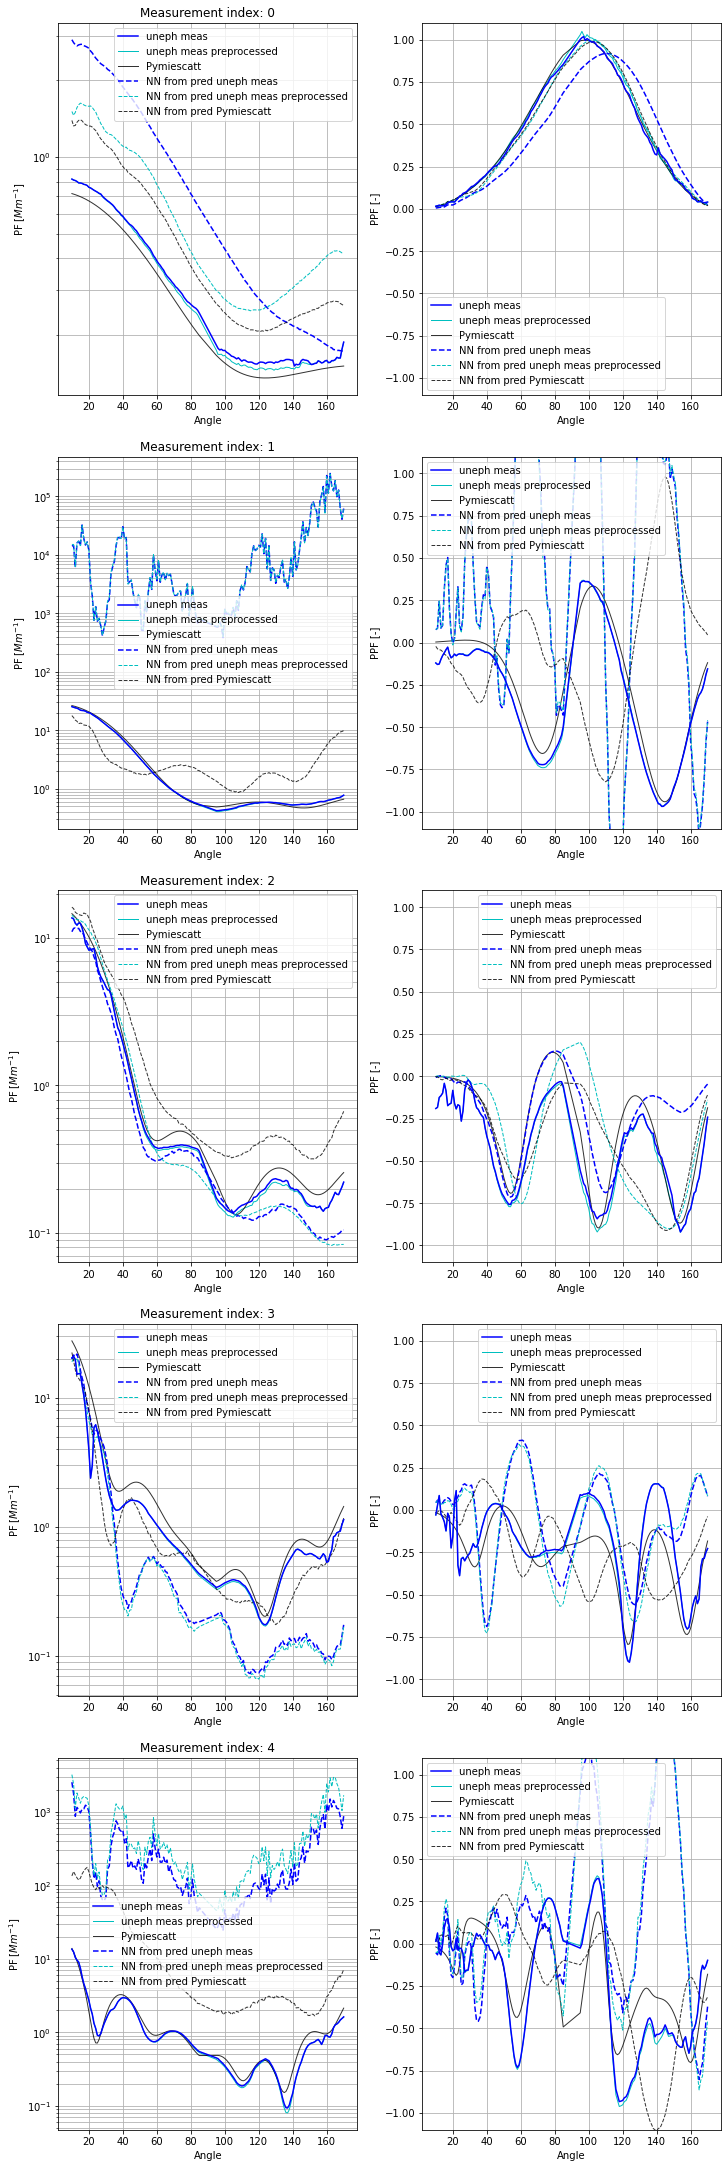

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


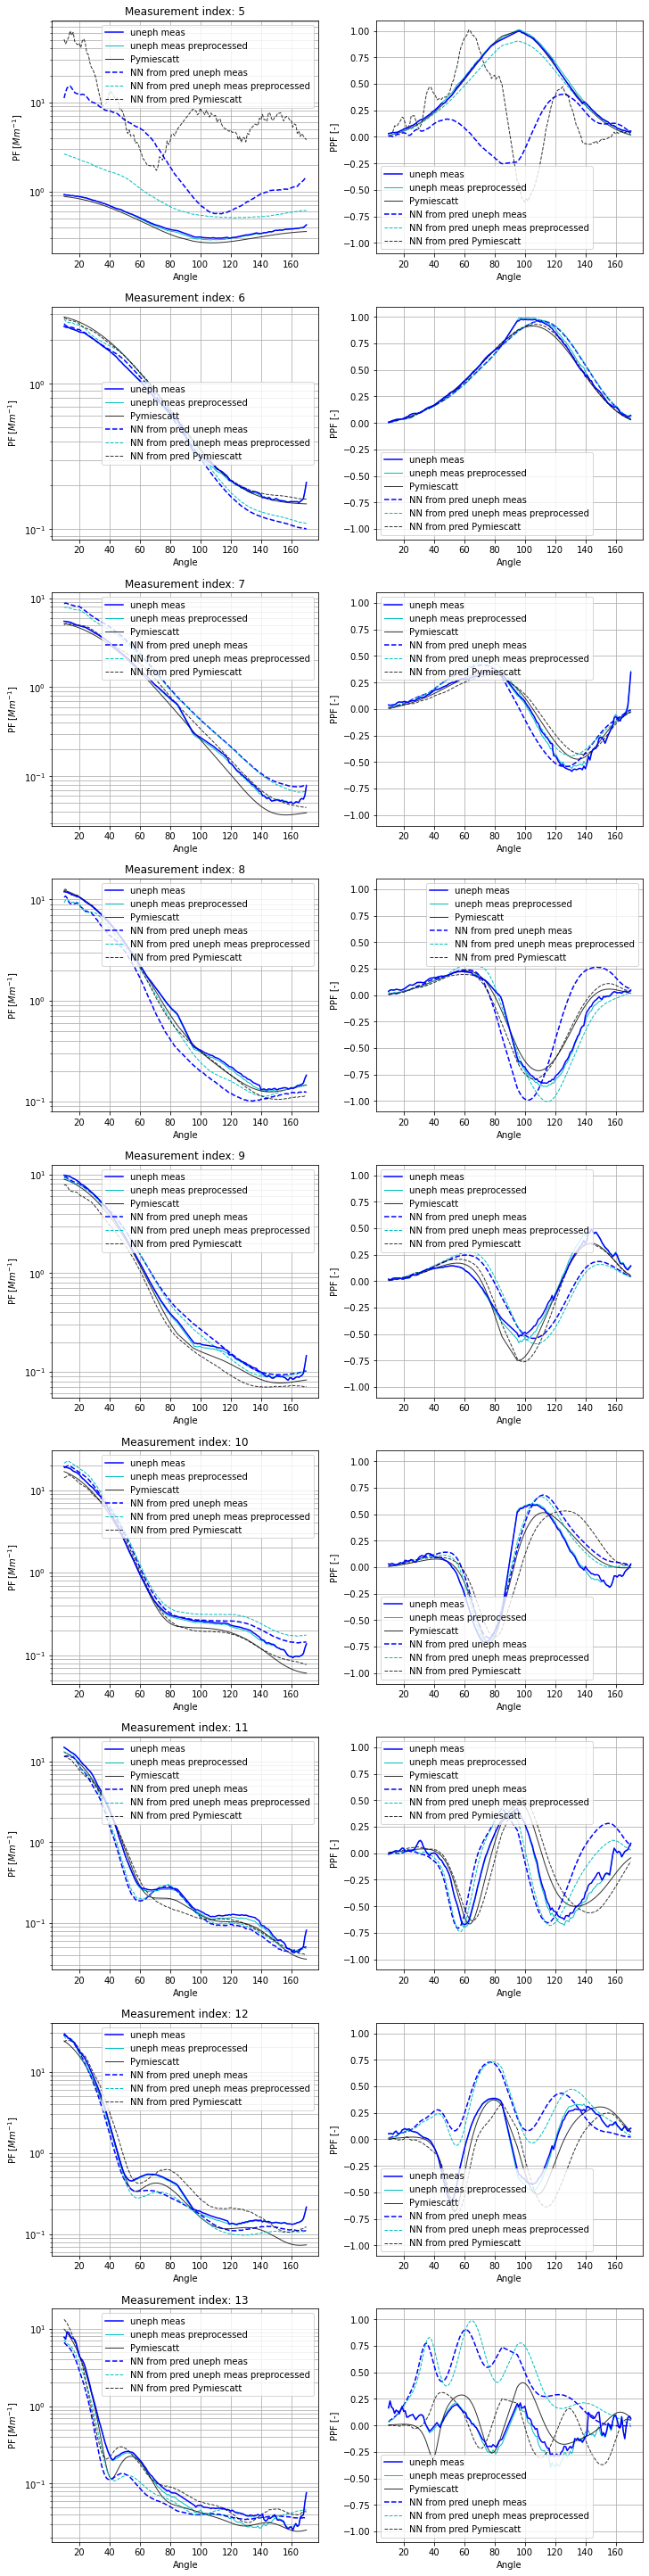

In [29]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index-5,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index-5,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,1].set_ylabel('PPF [-]')
    axs[index-5,1].set_ylim(-1.1, 1.1)
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [30]:
D_array = np.logspace(0.1, 5, 300)

In [31]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [32]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [ ]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

In [33]:
pms_qoi_meas_pred = pd.read_csv(f'{plot_dir}/pms_qoi_meas_pred.csv')

In [ ]:
# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

In [34]:
pms_qoi_meas_preprocessed_pred = pd.read_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv')

In [ ]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

In [35]:
pms_qoi_meas_pymiescatt_pred= pd.read_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv')

In [36]:
# Calculate relative error for aerosol retrieval

In [37]:
def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error

In [38]:
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

Vtot           41.585449
RmedianV       21.430220
GSD             2.829660
n             145.149440
k           38469.317153
dtype: float64
Vtot           35.365703
RmedianV       13.336137
GSD             2.925688
n             132.516271
k           17799.063853
dtype: float64
Vtot          38.761027
RmedianV      25.549473
GSD            1.278910
n            118.557008
k           8119.566613
dtype: float64


In [39]:
# Calculate relative error for forward simulation

In [40]:
qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')

<ipython-input-40-867fea1fd93e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')


In [41]:
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])

In [42]:
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)


In [43]:
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4

Vtot  RmedianV   GSD       n          k
meas_vs_pred               44.17     27.60  2.99  354.68  107524.20
meas_vs_preprocessed_pred  40.41     27.28  3.14  362.47   49639.90
meas_vs_pymiescatt_pred    46.11     17.75  1.64   11.98   22684.39

In [44]:
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

Vtot  RmedianV   GSD       n       k
meas_vs_pred               40.15     18.00  2.74   28.75  105.49
meas_vs_preprocessed_pred  32.57      5.59  2.80    4.77  109.71
meas_vs_pymiescatt_pred    34.68     29.88  1.08  177.77   28.00

In [45]:
rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

F11     PPF
meas_vs_pred                        97.43  181.33
meas_vs_meas_pred               572623.62  421.05
meas_vs_meas_preprocessed_pred  569089.35  440.13
meas_vs_meas_pymiescatt_pred       380.02  190.83

In [46]:
rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13

F11      PPF
meas_vs_pred                     17.69   752.00
meas_vs_meas_pred                83.54  1013.72
meas_vs_meas_preprocessed_pred   31.38  1449.04
meas_vs_meas_pymiescatt_pred    221.18   707.63

In [47]:
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

In [48]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1/plots_meas_original'